**Description**: Distributions of average, marginal effects. These plots are much easier
to interpret than ones about $\beta$. And they admit more noise b/c they're based on the
posterior predictive distribution.

**Runtime**: ~3 min.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
num_tests: list[int] = [200, 500]
effect_to_name: dict[str, str] = {
    "control": "pretraining boost",
    "treatment": "evaluation bias",
}

In [4]:
accuracies_home_dir = "accuracies_from_paper"
num_test_to_num_correct_df = {
    num_test: utils.load_all_num_correct(accuracies_home_dir, num_test)
    for num_test in num_tests
}
num_test_to_effect_to_summary = {
    num_test: {
        effect: az.from_netcdf(f"main_{num_test}_{effect}.nc")
        for effect in effect_to_name
    }
    for num_test in num_tests
}

In [5]:
num_test_to_diffs_df = {
    num_test: pl.DataFrame(
        {
            effect: utils.posterior_marginal_mean_diffs(
                num_test_to_effect_to_summary[num_test][effect],
                num_test_to_num_correct_df[num_test],
            )
            for effect in effect_to_name
        }
    )
    for num_test in num_tests
}

Marginalizing each draw:   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw:   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw:   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw:   0%|          | 0/4000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


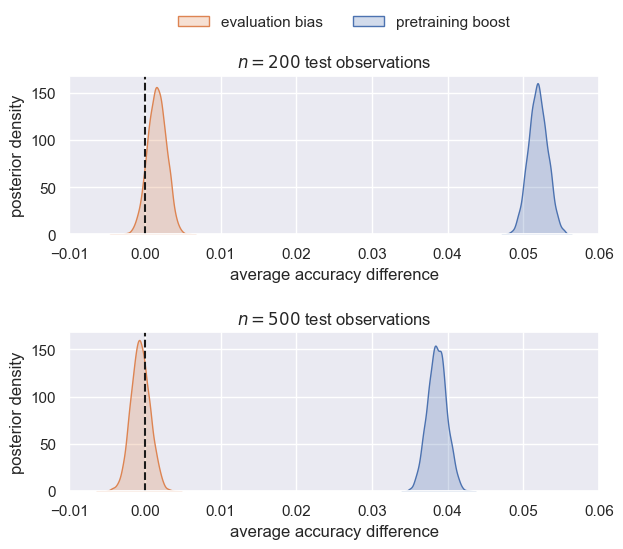

In [6]:
fig, axes = plt.subplots(nrows=len(num_tests), ncols=1)
xlim = (-0.01, 0.06)
axes: list[plt.Axes]
for subplot_idx, (num_test, diffs_df) in enumerate(num_test_to_diffs_df.items()):
    ax = axes[subplot_idx]
    _ = ax.set_xlim(xlim)
    _ = sns.kdeplot(ax=ax, data=diffs_df.rename(effect_to_name).to_pandas(), fill=True)
    ax.axvline(0, linestyle="dashed", color="k")
    _ = ax.set_xlabel("average accuracy difference")
    _ = ax.set_ylabel("posterior density")
    _ = ax.set_title(f"$n={{{num_test}}}$ test observations")

# fig.suptitle(f"Average accuracy differences\n", y=1.01)
fig.legend(
    handles=reversed(ax.legend_.legend_handles),
    labels=reversed([t.get_text() for t in ax.legend_.get_texts()]),
    ncol=2,
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.55, 1.07),
)

for ax in axes:
    ax.legend().set_visible(False)

fig.tight_layout()
plt.subplots_adjust(bottom=0.05)

We're looking at the distribution of $\bar{\hat{Y}}_{\cdot \cdot \cdot 1} -
\bar{\hat{Y}}_{\cdot \cdot \cdot 0}$, i.e., the difference between the treatment ($1$)
and control ($0$) grand means. The mean is taken across LM types, classification tasks,
and their subsamples. We could produce conditional plots for each of these groups, but
rn I want to summarize the results.

We get $\hat{Y}_{ijkl}$ by sampling from the posterior predictive distribution.